In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import multivariate_normal
from utils import randncor, score, plot_err,parzen_window 

plt.style.use(['seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.family'] = 'DejaVu Sans'

from IPython.display import HTML

# Исследование непараметрических алгоритмов оценивания плотности распределения случайной величины <a class="tocSkip">

# Постановка задачи

Задача оценки плотности распределения формулируется следующим образом.
Дана выборка $X = \big\{ x^{(1)}, ... ,x^{(N)}\big\}$- независимых и однинаково распределенных значений случайной величины __x__ из неизвестного распределения плотности $p(x)$. По этой выборке нужно найти некоторое приближение плотности $\tilde p(x) \approx p(x)$.

## Теория

Оценка плотности Парзена-Розенблатта в одномерном случае имеет вид:
$$p_h(x) = \frac{1}{mh}\sum_{i=1}^{m} K\Big(\frac{x-x^{(i)}}{h}\Big) $$, где $K(r)$ - ядро.

Рассматриваются следующие оконные функции:

- треугольная $(1)$
- прямоугольная $(2)$
- гауссовская с сиспользованием матрицы ковариаций
- гауссовская с использованием диагональной матрицы
- показательная

$$Π(r) = \frac{1}{2}[|r| ≤ 1] \tag{1}$$
$$T(r) = (1 − |r|)[r ≤ 1] \tag{2}$$
$$$$

# Решение

## Одномерный случай

### Найти абсолютную ошибку оценивания плотности распределения случайной величины и  ее зависимость от параметра h при использовании _показательной_ оконной функции

In [2]:
N = 1000
sample = np.matrix(np.random.exponential(size=N))

Показательное распределение имеет следующий вид:

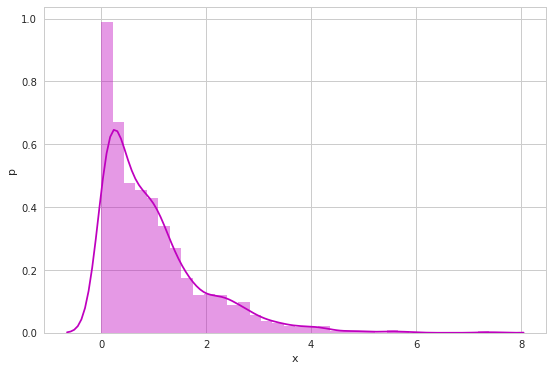

In [3]:
sns.distplot(sample,color='m');
plt.xlabel('x');
plt.ylabel('p');

Плотность распределения, которую мы будем оценивать:

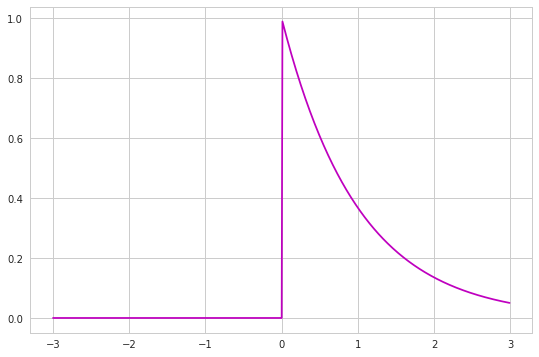

In [38]:
x0 = np.arange(-3,3,0.01)
ind = np.nonzero(x0>0) 
p = np.zeros([len(x0)])
p[ind] = np.exp(-x0[ind])
plt.plot(x0,p,c='m');

In [7]:
h_N = np.arange(0.01,1.01,0.01)
errors = []
pvs=[]
for j in range(len(h_N)):
    h = h_N[j]
    p_ = parzen_window(x0,sample,h,'exp')
    pvs.append(p_)
    err = score(p,p_)
    errors.append(err)

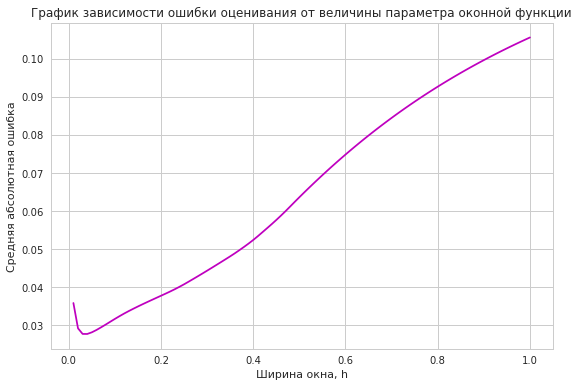

In [8]:
plot_err(h_N,errors)

In [13]:
print('Минимальная MAE = {:0.3f} достигается при ширине окна h = {}'.format(min(errors),h_N[errors.index(min(errors))]))

Минимальная MAE = 0.028 достигается при ширине окна h = 0.04


### Вычислить среднеквадратичную ошибку оценивания плотности распределения случайной величины  для окна вида:
<img src='img/problem.png' width = 400>

In [72]:
r = 0.5
N = 1000
h = N**(-r)
x0 = np.arange(-3,3.05,0.05)
p = np.exp(-x0**2/2)/np.sqrt(2*np.pi)
sample = np.matrix(np.random.randn(N))

In [73]:
p_ = parzen_window(x0,sample,h,'custom')
error = score(p,p_,scoring='mse')

In [74]:
print('Среднеквадратичная ошибка при использовании ядра указанного вида равна {:0.3f}'.format(error))

Среднеквадратичная ошибка при использовании ядра указанного вида равна 0.001


###  Окно какого вида будет обеспечивать оптимальное по критерию среднеквадратичной ошибки оценивание плотности распределения случайной величины? 

- гауссовская функция
- оконная прямоугольная функция 
- оконная треугольная функция

Построить графики зависимостей ошибок от объема обучающей выборки.


In [21]:
r = 0.5
N = [100,1000,10000]
kernels = ['gauss_diag','rect','tri']
x0 = np.arange(-3,3.05,0.05)
p = np.exp(-x0**2/2)/np.sqrt(2*np.pi)

In [18]:
errors = np.zeros([len(N),len(kernels)])
for i, n in enumerate(N):
    sample = np.matrix(np.random.randn(n))
    for j, kernel in enumerate(kernels):
        h_N = n**(-r)
        p_ = parzen_window(x0,sample,h_N,kernel)
        error = score(p,p_,scoring='mse')
        errors[i,j] = error

In [19]:
df = pd.DataFrame(errors,columns=kernels,index=N)
df

,gauss_diag,rect,tri
100,0.003560,0.007234,0.011613
1000,0.001249,0.002552,0.003721
10000,0.000407,0.000671,0.000901


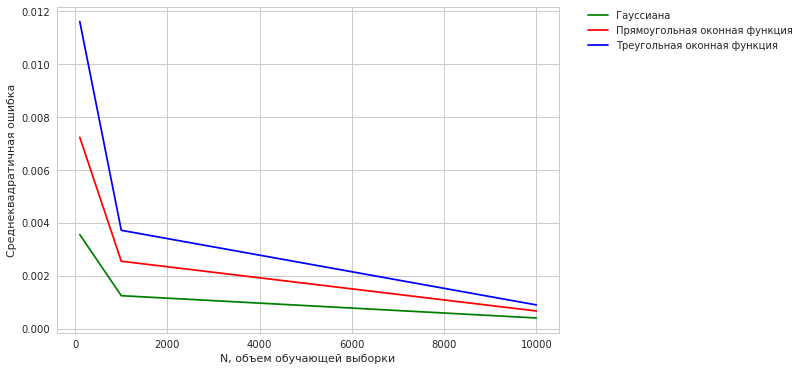

In [20]:
plt.plot(N,errors[:,0],'g', label = 'Гауссиана');
plt.plot(N,errors[:,1],'r', label = 'Прямоугольная оконная функция')
plt.plot(N,errors[:,2],'b', label = 'Треугольная оконная функция');
plt.xlabel('N, объем обучающей выборки')
plt.ylabel('Cреднеквадратичная ошибка')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Как можно видеть по графику, гауссиана(с использованием диагональной матрицы) обеспечивает оптимальную оценку плотности.

## Двумерный случай

В качестве примера мы будем рассматривать трехкомпонентную смесь гауссовских случайных векторов, имеющих одинаковую матрицу ковариаций. Зададим следующие параметры:
- n - размерность векторов
- ps - вероятности появления СВ различных типов в смеси
- D - дисперсия элементов
- ro - коэффициент корреляции

In [2]:
n = 2
ps=[0.2,0.3,0.5]

D=0.2
ro=-np.log(0.7)
m1=np.array([0,0])
m2=np.array([1,0])
m3=np.array([0,1])
m= [m1,m2,m3]

In [3]:
C = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        C[i,j]=D*np.exp(-ro*abs(i-j))
x1 = np.arange(-2,3,0.1) 
x2 = np.arange(-2,3,0.1) 
X1,X2 = np.meshgrid(x1,x2) 
x = np.vstack((X1.ravel(),X2.ravel()))
x_ = x.T

p = ps[0] * multivariate_normal.pdf(x_,m1,C) + \
    ps[1] * multivariate_normal.pdf(x_,m2,C) + \
    ps[2] * multivariate_normal.pdf(x_,m3,C)
pi = np.reshape(p,(len(x1),len(x2)))

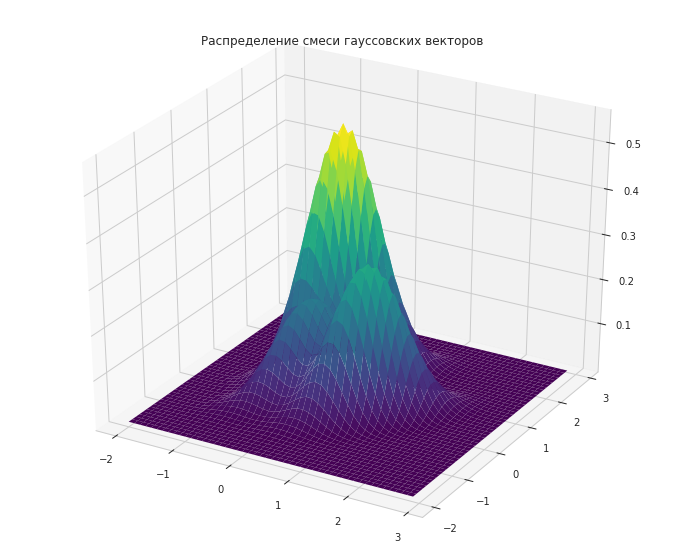

In [4]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, pi, cmap=plt.cm.viridis, linewidth=0.2);
ax.set_title('Распределение смеси гауссовских векторов');

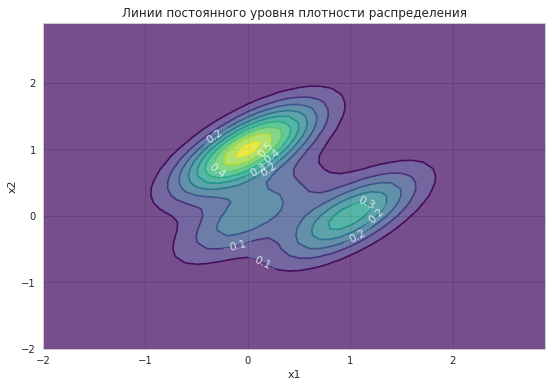

In [5]:
CS = plt.contourf(x1, x2, pi, 10, alpha=.75, cmap='viridis');
CS1 =plt.contour(x1, x2, pi, 10, alpha=.75, cmap='viridis');
plt.clabel(CS1, fmt='%2.1f', colors='w', fontsize=11)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Линии постоянного уровня плотности распределения');

Сгенерируем обучающую выборку размером N = 1000. Для генерации реализаций случайных векторов $x = Au$  будем использовать функцию randcor. К полученным значениям будем прибавлять математическое ожидание, выбранное случайным образом. Так мы будем относить сгенерированные вектора к той или иной компоненте смеси.

In [6]:
N = 1000
def generate_sample(n,N,ps):
    XN = np.zeros([n,N])
    for i in range(N):
        u = np.random.uniform()
        if u<ps[0]:
            t = 0
        elif u<ps[0]+ps[1]:
            t = 1
        else:
            t = 2
        XN[:,i] =(randncor(n,1,C) + m[t].reshape(-1,1)).T
    return XN

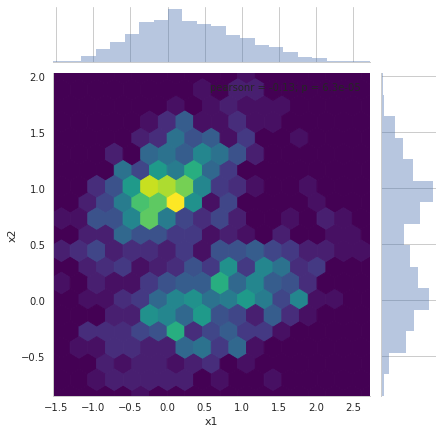

In [27]:
XN = generate_sample(n,N,ps)
ax = sns.jointplot(x=XN[0,:], y=XN[1,:], kind='hex',cmap = 'viridis',);
ax.set_axis_labels('x1','x2');

### Найти абсолютную ошибку оценивания плотности распределения случайного вектора в двумерном пространстве и ее зависимость от параметра h при использовании _треугольной_ оконной функции

In [28]:
h_N = np.arange(0.01,1.01,0.01)
errors = []
pvs=[]
for j in range(len(h_N)):
    h = h_N[j]
    p_ = parzen_window(x,XN,h,'tri')
    pv = np.reshape(p_,(len(x1),len(x2)))
    pvs.append(pv)
    err = score(pi,pv)
    errors.append(err)

In [27]:
from IPython.display import HTML
HTML('<img src="img/density-prob.gif">')

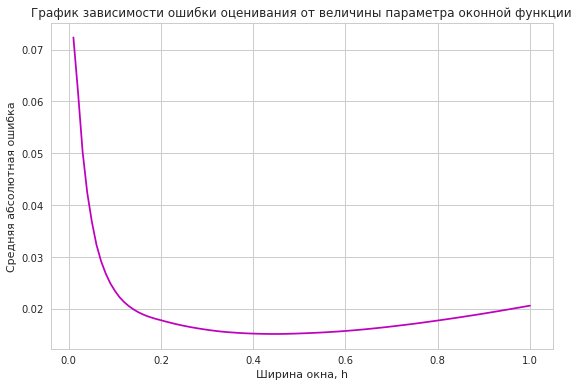

In [33]:
plot_err(h_N,errors)

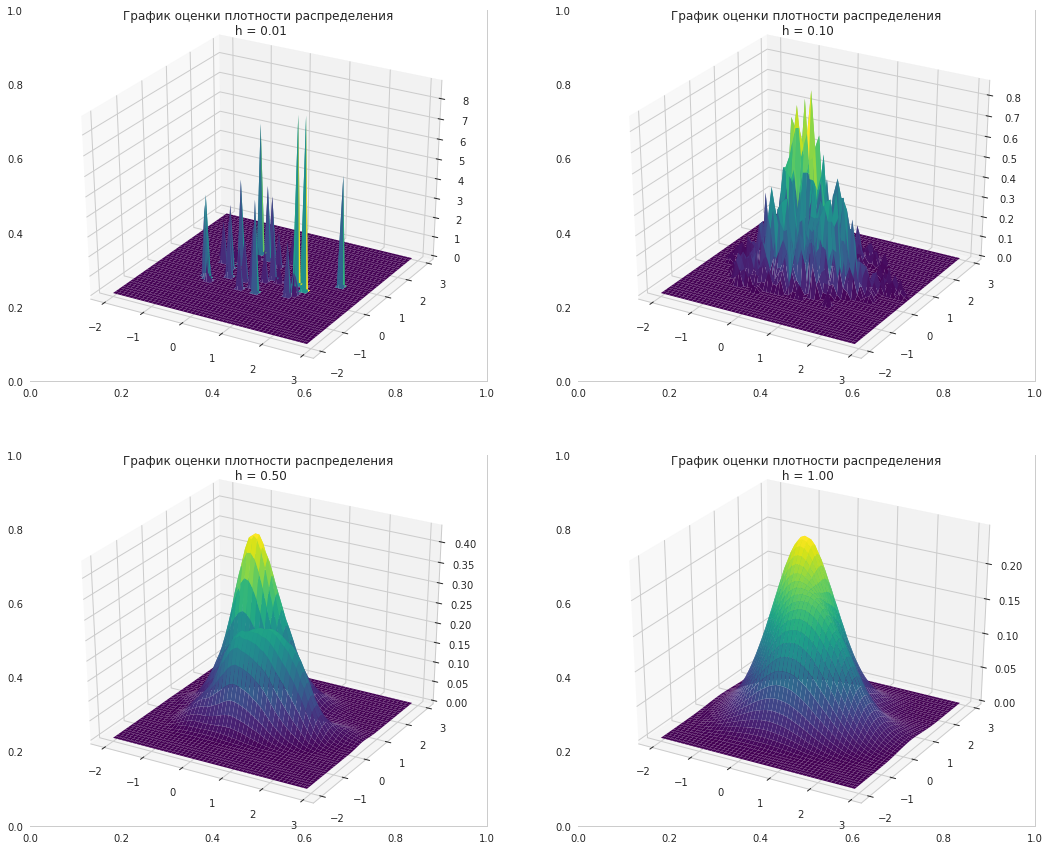

In [30]:
ind = [0,9,49,99]
h_N_selected = h_N[ind]
fig,axs = plt.subplots(ncols = 2,nrows = 2, figsize=(18,15))
for i, j in enumerate(ind):
    ax = fig.add_subplot(2,2,i+1,projection='3d')
    ax.plot_surface(X1, X2, pvs[j], cmap=plt.cm.viridis, linewidth=0.2);
    ax.set_title('График оценки плотности распределения\n h = {:0.2f}'.format(h_N_selected[i]));

Найдем ширину окна, при которой величина средней абсолютной ошибки является минимальной для данной выборки.

In [31]:
ind = errors.index(min(errors))
h_best = h_N[ind]
print('Ширина окна, при которой оценка плотности является наилучшей = {:0.2f}'.format(h_best))

Ширина окна, при которой оценка плотности является наилучшей = 0.44


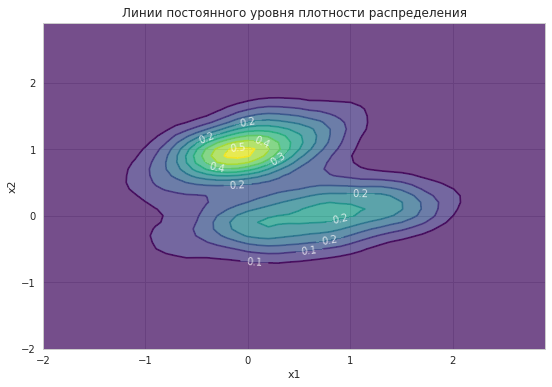

In [32]:
S = plt.contourf(x1, x2, pvs[ind], 10, alpha=.75, cmap='viridis');
CS1 =plt.contour(x1, x2, pvs[ind], 10, alpha=.75, cmap='viridis');
plt.clabel(CS1, fmt='%2.1f', colors='w', fontsize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Линии постоянного уровня плотности распределения');

Трехмерные визуализации плотности распределения и ее оценки можно посмотреть по ссылкам:<br>
https://plot.ly/~mzaharchenko/16/ <br>
https://plot.ly/~mzaharchenko/14/


###  Окно какого вида будет обеспечивать оптимальное по критерию среднеквадратичной ошибки оценивание плотности распределения двумерного случайного вектора?
 
- гауссовская функция c использованием диагональной матрицы 
- гауссовская функция c использованием матрицы ковариаций

Построить графики зависимостей ошибок от объема обучающей выборки.

In [37]:
r = 0.5
N = [100,1000,10000]
kernels = ['gauss_diag','gauss_cov']

In [34]:
errors = np.zeros([len(N),len(kernels)])
for i, n in enumerate(N):
    sample = generate_sample(2,n,ps)
    for j, kernel in enumerate(kernels):
        h_N=n**(-r/2)
        p_ = parzen_window(x,sample,h_N,kernel)
        pv = np.reshape(p_,(len(x1),len(x2)))
        error = score(pi,pv,scoring='mse')
        errors[i,j] = error

In [65]:
df = pd.DataFrame(errors,columns=kernels,index=N)

In [66]:
df

,gauss_diag,gauss_cov
100,0.002242,0.002566
1000,0.000886,0.001090
10000,0.000801,0.000915


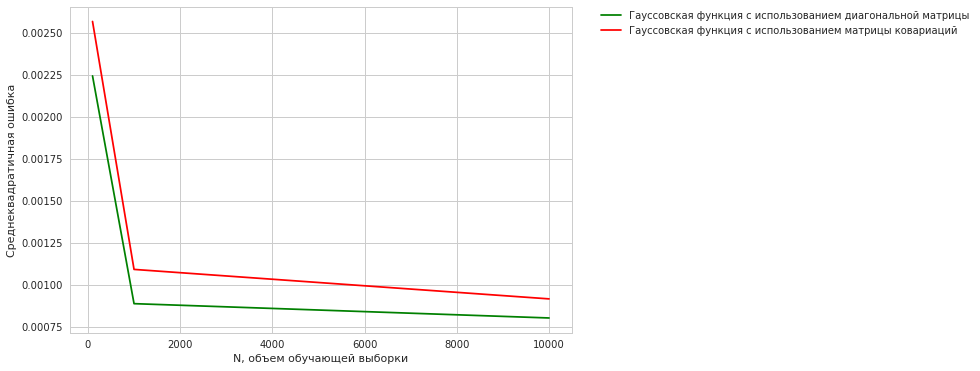

In [67]:
plt.plot(N,errors[:,0],'g', label = 'Гауссовская функция c использованием диагональной матрицы');
plt.plot(N,errors[:,1],'r', label = 'Гауссовская функция c использованием матрицы ковариаций')
plt.xlabel('N, объем обучающей выборки')
plt.ylabel('Cреднеквадратичная ошибка')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Гауссовская функция с использованием диагональной матрицы обеспечивает оптимальное по критерию среднеквадратичной ошибки оценивание плотности распределения двумерного случайного вектора.

***

Код метода парзеновского окна доступен <a href='https://gist.github.com/mzaharchenko/9a5d6c0bd8b8a812182b3eeebed18f3a'>тут</a>